In [185]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
#Functions


from keras import backend as K

def oversampler(X, y):    
    X = list(X)
    counter = int(y.mean() * len(y))
    while counter / len(y) < 0.5:
        for i in range(len(y)):
            if y[i] == 1:
                X.append(X[i])
                y = np.append(y, y[i])
                counter += 1
            if counter / len(y) >= 0.5:
                break
    X = np.array(X)
    return X, y

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [186]:
dataset_path = "hfactory_magic_folders/colas_data_challenge/computer_vision_challenge/dataset/"

In [187]:
train_labels = pd.read_csv(dataset_path + "labels_train.csv")


In [188]:
train_labels

,filename,FISSURE,REPARATION,FISSURE LONGITUDINALE,FAÏENCAGE,MISE EN DALLE
0,BDCAEROD0000000017183099_runway_3_gridsize_512...,0,0,1,1,0
1,BDCAEROD0000000017183055_runway_1_gridsize_512...,0,0,1,0,0
2,BDCAEROD0000000017183118_runway_1_gridsize_512...,1,0,1,0,0
3,BDCAEROD0000000017183028_runway_1_gridsize_512...,1,0,0,0,0
4,BDCAEROD0000000017183088_runway_1_gridsize_512...,0,0,0,0,0
...,...,...,...,...,...,...
825,BDCAEROD0000000017183055_runway_1_gridsize_512...,0,0,0,0,0
826,BDCAEROD0000000017183095_runway_1_gridsize_512...,1,1,1,0,1
827,BDCAEROD0000000017182994_runway_1_gridsize_512...,0,1,0,1,0
828,BDCAEROD0000000017183099_runway_3_gridsize_512...,0,1,1,1,0


In [189]:
train_image = []
for i in tqdm(range(train_labels.shape[0])):
    img = load_img(dataset_path + "train/" + train_labels["filename"][i], target_size=(224,224,3))
    img = img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 830/830 [00:05<00:00, 153.79it/s]


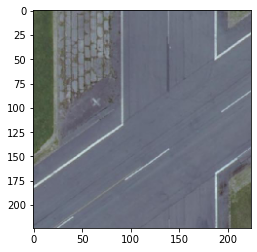

In [190]:
plt.imshow(X[2])

In [191]:
y = np.array(train_labels.drop(["filename"], axis=1))

### One Model for Each Output

In [193]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False

In [194]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc', AUC()])

In [219]:
y_fissure = np.array(train_labels["FISSURE"])
y_reparation = np.array(train_labels["REPARATION"])
y_longi = np.array(train_labels["FISSURE LONGITUDINALE"])
y_faience = np.array(train_labels["FAÏENCAGE"])
y_med = np.array(train_labels["MISE EN DALLE"])

In [220]:
print(y_fissure.mean())
print(y_reparation.mean())
print(y_longi.mean())
print(y_faience.mean())
print(y_med.mean())
print(len(y_fissure))

0.30481927710843376
0.12530120481927712
0.26987951807228916
0.05903614457831325
0.13132530120481928
830


#### FISSURE

In [221]:
X_fissure_train, X_fissure_test, y_fissure_train, y_fissure_test = train_test_split(X, y_fissure, test_size=0.2)


In [222]:
X_fissure_train, y_fissure_train = oversampler(X_fissure_train, y_fissure_train) 

In [223]:
print(len(y_fissure_train))
print(y_fissure_train.mean())
print(X_fissure_train.shape)

932
0.5
(932, 224, 224, 3)


In [224]:
vgg1hist = model.fit(X_fissure_train, y_fissure_train, validation_data = (X_fissure_test, y_fissure_test), epochs = 20, batch_size = 32)


Epoch 1/20
30/30 [==============================] - 3s 99ms/step - loss: 0.3952 - acc: 0.8734 - auc_2: 0.9378 - val_loss: 0.3745 - val_acc: 0.8554 - val_auc_2: 0.9494
Epoch 2/20
30/30 [==============================] - 2s 54ms/step - loss: 0.2845 - acc: 0.8959 - auc_2: 0.9581 - val_loss: 0.2503 - val_acc: 0.9157 - val_auc_2: 0.9577
Epoch 3/20
30/30 [==============================] - 2s 54ms/step - loss: 0.2474 - acc: 0.9131 - auc_2: 0.9656 - val_loss: 0.2316 - val_acc: 0.9398 - val_auc_2: 0.9589
Epoch 4/20
30/30 [==============================] - 2s 53ms/step - loss: 0.2037 - acc: 0.9238 - auc_2: 0.9747 - val_loss: 0.2546 - val_acc: 0.9277 - val_auc_2: 0.9554
Epoch 5/20
30/30 [==============================] - 2s 54ms/step - loss: 0.1712 - acc: 0.9496 - auc_2: 0.9806 - val_loss: 0.3925 - val_acc: 0.8494 - val_auc_2: 0.9613
Epoch 6/20
30/30 [==============================] - 2s 54ms/step - loss: 0.1623 - acc: 0.9474 - auc_2: 0.9826 - val_loss: 0.2530 - val_acc: 0.9277 - val_auc_2: 0.961

#### REPARATION

In [225]:
X_reparation_train, X_reparation_test, y_reparation_train, y_reparation_test = train_test_split(X, y_reparation, test_size=0.2)


In [226]:
X_reparation_train, y_reparation_train = oversampler(X_reparation_train, y_reparation_train) 

In [227]:
print(len(y_reparation_train))
print(y_reparation_train.mean())
print(X_reparation_train.shape)

1166
0.5
(1166, 224, 224, 3)


In [228]:
vgg2hist = model.fit(X_reparation_train, y_reparation_train, validation_data = (X_reparation_test, y_reparation_test), epochs = 20, batch_size = 32)


Epoch 1/20
37/37 [==============================] - 3s 83ms/step - loss: 0.6119 - acc: 0.8345 - auc_2: 0.8781 - val_loss: 0.3484 - val_acc: 0.8313 - val_auc_2: 0.9109
Epoch 2/20
37/37 [==============================] - 2s 51ms/step - loss: 0.2678 - acc: 0.9168 - auc_2: 0.9568 - val_loss: 0.2791 - val_acc: 0.8554 - val_auc_2: 0.9272
Epoch 3/20
37/37 [==============================] - 2s 52ms/step - loss: 0.2119 - acc: 0.9288 - auc_2: 0.9688 - val_loss: 0.2394 - val_acc: 0.8916 - val_auc_2: 0.9138
Epoch 4/20
37/37 [==============================] - 2s 52ms/step - loss: 0.1801 - acc: 0.9434 - auc_2: 0.9776 - val_loss: 0.2408 - val_acc: 0.8795 - val_auc_2: 0.9167
Epoch 5/20
37/37 [==============================] - 2s 52ms/step - loss: 0.1426 - acc: 0.9597 - auc_2: 0.9883 - val_loss: 0.2874 - val_acc: 0.8675 - val_auc_2: 0.9162
Epoch 6/20
37/37 [==============================] - 2s 53ms/step - loss: 0.1326 - acc: 0.9520 - auc_2: 0.9891 - val_loss: 0.2933 - val_acc: 0.8735 - val_auc_2: 0.908

#### FISSURE LONGITUDINALE

In [229]:
X_longi_train, X_longi_test, y_longi_train, y_longi_test = train_test_split(X, y_longi, test_size=0.2)


In [230]:
X_longi_train, y_longi_train = oversampler(X_longi_train, y_longi_train) 

In [231]:
print(len(y_longi_train))
print(y_longi_train.mean())
print(X_longi_train.shape)

972
0.5
(972, 224, 224, 3)


In [232]:
vgg3hist = model.fit(X_longi_train, y_longi_train, validation_data = (X_longi_test, y_longi_test), epochs = 20, batch_size = 32)


Epoch 1/20
31/31 [==============================] - 2s 55ms/step - loss: 0.6663 - acc: 0.7891 - auc_2: 0.8479 - val_loss: 0.2215 - val_acc: 0.8916 - val_auc_2: 0.9675
Epoch 2/20
31/31 [==============================] - 2s 53ms/step - loss: 0.3295 - acc: 0.8817 - auc_2: 0.9370 - val_loss: 0.1720 - val_acc: 0.9398 - val_auc_2: 0.9798
Epoch 3/20
31/31 [==============================] - 2s 53ms/step - loss: 0.2455 - acc: 0.9126 - auc_2: 0.9634 - val_loss: 0.1927 - val_acc: 0.9217 - val_auc_2: 0.9790
Epoch 4/20
31/31 [==============================] - 2s 54ms/step - loss: 0.2283 - acc: 0.9146 - auc_2: 0.9680 - val_loss: 0.1639 - val_acc: 0.9398 - val_auc_2: 0.9781
Epoch 5/20
31/31 [==============================] - 2s 53ms/step - loss: 0.2409 - acc: 0.9033 - auc_2: 0.9617 - val_loss: 0.1677 - val_acc: 0.9398 - val_auc_2: 0.9780
Epoch 6/20
31/31 [==============================] - 2s 54ms/step - loss: 0.1808 - acc: 0.9383 - auc_2: 0.9800 - val_loss: 0.2193 - val_acc: 0.9217 - val_auc_2: 0.972

#### FAIENÇAGE

In [233]:
X_faience_train, X_faience_test, y_faience_train, y_faience_test = train_test_split(X, y_faience, test_size=0.2)


In [234]:
X_faience_train, y_faience_train = oversampler(X_faience_train, y_faience_train) 

In [235]:
print(len(y_faience_train))
print(y_faience_train.mean())
print(X_faience_train.shape)

1250
0.5
(1250, 224, 224, 3)


In [236]:
vgg4hist = model.fit(X_faience_train, y_faience_train, validation_data = (X_faience_test, y_faience_test), epochs = 20, batch_size = 32)


Epoch 1/20
40/40 [==============================] - 3s 64ms/step - loss: 0.4222 - acc: 0.8536 - auc_2: 0.9101 - val_loss: 0.3930 - val_acc: 0.7831 - val_auc_2: 0.9349
Epoch 2/20
40/40 [==============================] - 2s 51ms/step - loss: 0.2524 - acc: 0.9088 - auc_2: 0.9546 - val_loss: 0.1444 - val_acc: 0.9398 - val_auc_2: 0.9260
Epoch 3/20
40/40 [==============================] - 2s 54ms/step - loss: 0.1951 - acc: 0.9264 - auc_2: 0.9721 - val_loss: 0.1547 - val_acc: 0.9398 - val_auc_2: 0.9224
Epoch 4/20
40/40 [==============================] - 2s 51ms/step - loss: 0.1550 - acc: 0.9464 - auc_2: 0.9832 - val_loss: 0.1845 - val_acc: 0.9277 - val_auc_2: 0.9141
Epoch 5/20
40/40 [==============================] - 2s 52ms/step - loss: 0.1219 - acc: 0.9576 - auc_2: 0.9909 - val_loss: 0.2807 - val_acc: 0.8494 - val_auc_2: 0.9138
Epoch 6/20
40/40 [==============================] - 2s 51ms/step - loss: 0.1048 - acc: 0.9672 - auc_2: 0.9931 - val_loss: 0.1974 - val_acc: 0.9217 - val_auc_2: 0.905

#### MISE EN DALLE

In [237]:
X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(X, y_med, test_size=0.2)

In [238]:
X_med_train, y_med_train = oversampler(X_med_train, y_med_train) 

In [239]:
print(len(y_med_train))
print(y_med_train.mean())
print(X_med_train.shape)

1150
0.5
(1150, 224, 224, 3)


In [240]:
vgg5hist = model.fit(X_med_train, y_med_train, validation_data = (X_med_test, y_med_test), epochs = 20, batch_size = 32)


Epoch 1/20
36/36 [==============================] - 2s 58ms/step - loss: 0.4622 - acc: 0.8817 - auc_2: 0.9228 - val_loss: 0.2430 - val_acc: 0.8795 - val_auc_2: 0.9604
Epoch 2/20
36/36 [==============================] - 2s 53ms/step - loss: 0.2123 - acc: 0.9365 - auc_2: 0.9682 - val_loss: 0.1736 - val_acc: 0.9337 - val_auc_2: 0.9637
Epoch 3/20
36/36 [==============================] - 2s 52ms/step - loss: 0.1850 - acc: 0.9365 - auc_2: 0.9741 - val_loss: 0.1607 - val_acc: 0.9518 - val_auc_2: 0.9661
Epoch 4/20
36/36 [==============================] - 2s 54ms/step - loss: 0.1546 - acc: 0.9574 - auc_2: 0.9806 - val_loss: 0.1947 - val_acc: 0.9277 - val_auc_2: 0.9570
Epoch 5/20
36/36 [==============================] - 2s 52ms/step - loss: 0.1448 - acc: 0.9574 - auc_2: 0.9826 - val_loss: 0.1729 - val_acc: 0.9398 - val_auc_2: 0.9476
Epoch 6/20
36/36 [==============================] - 2s 53ms/step - loss: 0.1196 - acc: 0.9661 - auc_2: 0.9892 - val_loss: 0.1787 - val_acc: 0.9277 - val_auc_2: 0.948